# Load Data

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
data_path = '/Users/christopherwmurphy/Documents/projects/lhc_olympics/LHC-Olympics-2020/data_processed'

In [3]:
df = pd.read_hdf(os.path.join(data_path, 'processed_labeled.h5'), key='processed')

In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1099809 entries, 0 to 1099808
Data columns (total 26 columns):
pt_1                       1099809 non-null float64
eta_1                      1099809 non-null float64
phi_1                      1099809 non-null float64
mass_1                     1099809 non-null float64
pt_2                       1099809 non-null float64
eta_2                      1099809 non-null float64
phi_2                      1099809 non-null float64
mass_2                     1099809 non-null float64
sqrt(tau1(2))/tau1(1)_1    1099809 non-null float64
tau21_1                    1099809 non-null float64
tau32_1                    1099809 non-null float64
tau43_1                    1099809 non-null float64
multiplicity_1             1099809 non-null int64
fragmentation_1            1099809 non-null float64
sqrt(tau1(2))/tau1(1)_2    1099809 non-null float64
tau21_2                    1099809 non-null float64
tau32_2                    1099809 non-null float64
tau43

# Feature Selection for Outlier Detection

If the ROC AUC is greater than 1/2 keep this feature. Note this is usually trivial to satisfy, but if the background is "more outlying" than the signal then performance will suffer

In [5]:
X = df.drop(columns=['is_signal'])
y = df['is_signal']

In [6]:
from pyod.models.iforest import IForest
from pyod.utils.data import evaluate_print

In [7]:
%%time
for feature in X.columns:
    clf = IForest(behaviour='new', n_estimators=20)
    clf.fit(X[feature].values.reshape(-1, 1))
    evaluate_print(feature, y, clf.decision_scores_)

pt_1 ROC:0.7235, precision @ rank n:0.1477
eta_1 ROC:0.4586, precision @ rank n:0.0515
phi_1 ROC:0.5007, precision @ rank n:0.0919
mass_1 ROC:0.5884, precision @ rank n:0.1595
pt_2 ROC:0.7287, precision @ rank n:0.0902
eta_2 ROC:0.4414, precision @ rank n:0.051
phi_2 ROC:0.4997, precision @ rank n:0.091
mass_2 ROC:0.5342, precision @ rank n:0.1695
sqrt(tau1(2))/tau1(1)_1 ROC:0.608, precision @ rank n:0.079
tau21_1 ROC:0.6526, precision @ rank n:0.2271
tau32_1 ROC:0.5738, precision @ rank n:0.1454
tau43_1 ROC:0.5324, precision @ rank n:0.1211
multiplicity_1 ROC:0.4235, precision @ rank n:0.0339
fragmentation_1 ROC:0.4186, precision @ rank n:0.0266
sqrt(tau1(2))/tau1(1)_2 ROC:0.5815, precision @ rank n:0.0416
tau21_2 ROC:0.5722, precision @ rank n:0.1928
tau32_2 ROC:0.5467, precision @ rank n:0.1392
tau43_2 ROC:0.5268, precision @ rank n:0.1246
multiplicity_2 ROC:0.4281, precision @ rank n:0.0349
fragmentation_2 ROC:0.404, precision @ rank n:0.0293
delta_phi_jj ROC:0.4188, precision @ ra

# Outlier Detector Comparison

PCA outperforms the autoencoder I trained

In [7]:
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.pca import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

Using TensorFlow backend.


Based on the above feature selection keep the following features for anomaly detection

In [8]:
od_cols = ['pt_1', 'pt_2', 'sqrt(tau1(2))/tau1(1)_1', 'tau21_1', 'tau32_1', 'tau43_1',
           'sqrt(tau1(2))/tau1(1)_2', 'tau21_2', 'tau32_2', 'tau43_2','mass_1+mass_2', '|mass_1-mass_2|']

In [9]:
X1 = df[od_cols]

In [10]:
X_tr, X_te, y_tr, y_te = train_test_split(X1, y, test_size=0.2, stratify=y)

In [11]:
quant = QuantileTransformer()
X_tr = quant.fit_transform(X_tr)
X_te = quant.transform(X_te)

## Principal Component Analysis

In [16]:
%%time
for i in range(1, X1.shape[1]+1):
    od = PCA(n_components=i)
    od.fit(X_tr)
    evaluate_print('PCA w/ %i components' %i, y_te, od.decision_function(X_te))

PCA w/ 1 components ROC:0.4195, precision @ rank n:0.0091
PCA w/ 2 components ROC:0.7048, precision @ rank n:0.1655
PCA w/ 3 components ROC:0.7685, precision @ rank n:0.256
PCA w/ 4 components ROC:0.7958, precision @ rank n:0.3034
PCA w/ 5 components ROC:0.8065, precision @ rank n:0.3282
PCA w/ 6 components ROC:0.8127, precision @ rank n:0.3418
PCA w/ 7 components ROC:0.8182, precision @ rank n:0.3524
PCA w/ 8 components ROC:0.8164, precision @ rank n:0.3454
PCA w/ 9 components ROC:0.8249, precision @ rank n:0.3629
PCA w/ 10 components ROC:0.8299, precision @ rank n:0.3749
PCA w/ 11 components ROC:0.8389, precision @ rank n:0.3944
PCA w/ 12 components ROC:0.8386, precision @ rank n:0.3946
CPU times: user 45 s, sys: 7.37 s, total: 52.4 s
Wall time: 28.4 s


In [17]:
%%time
for i in range(1, X1.shape[1]+1):
    od = PCA(n_components=12, n_selected_components=i)
    od.fit(X_tr)
    evaluate_print('PCA w/ %i selected components' %i, y_te, od.decision_function(X_te))

PCA w/ 1 selected components ROC:0.8306, precision @ rank n:0.3807
PCA w/ 2 selected components ROC:0.8491, precision @ rank n:0.4199
PCA w/ 3 selected components ROC:0.8478, precision @ rank n:0.4197
PCA w/ 4 selected components ROC:0.8469, precision @ rank n:0.4147
PCA w/ 5 selected components ROC:0.8434, precision @ rank n:0.4069
PCA w/ 6 selected components ROC:0.8432, precision @ rank n:0.4066
PCA w/ 7 selected components ROC:0.8427, precision @ rank n:0.4048
PCA w/ 8 selected components ROC:0.8423, precision @ rank n:0.404
PCA w/ 9 selected components ROC:0.8423, precision @ rank n:0.4028
PCA w/ 10 selected components ROC:0.8426, precision @ rank n:0.4028
PCA w/ 11 selected components ROC:0.8426, precision @ rank n:0.4039
PCA w/ 12 selected components ROC:0.8386, precision @ rank n:0.3946
CPU times: user 14.7 s, sys: 2.84 s, total: 17.6 s
Wall time: 13.2 s


In [18]:
%%time
for i in range(1, 12):
    od = PCA(n_components=11, n_selected_components=i)
    od.fit(X_tr)
    evaluate_print('PCA w/ %i selected components' %i, y_te, od.decision_function(X_te))

PCA w/ 1 selected components ROC:0.8627, precision @ rank n:0.452
PCA w/ 2 selected components ROC:0.8543, precision @ rank n:0.4369
PCA w/ 3 selected components ROC:0.851, precision @ rank n:0.4261
PCA w/ 4 selected components ROC:0.8456, precision @ rank n:0.4127
PCA w/ 5 selected components ROC:0.8452, precision @ rank n:0.4108
PCA w/ 6 selected components ROC:0.8444, precision @ rank n:0.4093
PCA w/ 7 selected components ROC:0.8438, precision @ rank n:0.4079
PCA w/ 8 selected components ROC:0.8437, precision @ rank n:0.4064
PCA w/ 9 selected components ROC:0.8439, precision @ rank n:0.4054
PCA w/ 10 selected components ROC:0.8439, precision @ rank n:0.4058
PCA w/ 11 selected components ROC:0.8389, precision @ rank n:0.3944
CPU times: user 13.4 s, sys: 2.58 s, total: 16 s
Wall time: 12 s


## Isolation Forest

In [18]:
n_range = [10, 20, 50, 70, 100]

In [19]:
%%time
for n in n_range:
    od = IForest(behaviour='new', n_estimators=n)
    od.fit(X_tr)
    evaluate_print('IForest w/ %i estimators' %n, y_te, od.decision_function(X_te))

IForest w/ 10 estimators ROC:0.6404, precision @ rank n:0.1772
IForest w/ 20 estimators ROC:0.6298, precision @ rank n:0.1577
IForest w/ 50 estimators ROC:0.7245, precision @ rank n:0.1845
IForest w/ 70 estimators ROC:0.6829, precision @ rank n:0.1584
IForest w/ 100 estimators ROC:0.654, precision @ rank n:0.1425
CPU times: user 2min 28s, sys: 17.7 s, total: 2min 46s
Wall time: 2min 47s


## Autoencoder

In [15]:
%%time
od = AutoEncoder(hidden_neurons=[8, 4, 8], epochs=5, batch_size=150, validation_size=0., dropout_rate=0., l2_regularizer=0.001)
od.fit(X_tr)
evaluate_print('Autoencoder', y_te, od.decision_function(X_te))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_18 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_19 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 104       
_________________________________________________________________
dropout_20 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 4)                

# Feature Selection for Classification

In CWoLa we will be training on signal region vs. sideband region. However what we're really interested in is signal vs. background. Therefore we need features that are good at identifying signal as opposed to the signal region. The ROC AUC is misleading here. A classifier that is great at seperating signal region from sideband region will not be helpful in determining the amount of background in the signal region.

In [11]:
df2 = df[(df['mass_jj'] >= 2950) & (df['mass_jj'] <= 4050)].copy()

In [12]:
df2['signal_region'] = ((df2['mass_jj'] >= 3250) & (df2['mass_jj'] <= 3750)).astype('int64')

## Outlier Detectors as Classification Features

In [13]:
quant2 = QuantileTransformer()
X2_tr = quant2.fit_transform(df[od_cols])
X2_te = quant2.transform(df2[od_cols])

In [14]:
feat_pca = PCA(n_components=11, n_selected_components=1)
feat_pca.fit(X2_tr)
df2['pca'] = feat_pca.decision_function(X2_te)

In [15]:
feat_iforest = IForest(behaviour='new', n_estimators=50)
feat_iforest.fit(X2_tr)
df2['iforest'] = feat_iforest.decision_function(X2_te)

In [16]:
feat_autoencoder = AutoEncoder(hidden_neurons=[8, 4, 4, 8], epochs=3, validation_size=0.)
feat_autoencoder.fit(X2_tr)
df2['autoencoder'] = feat_autoencoder.decision_function(X2_te)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 104       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         


## Feature Selection using XGBoost

In [17]:
X3 = df2.drop(columns=['is_signal', 'signal_region'])
y1 = df2['signal_region']
y2 = df2['is_signal']

In [18]:
from xgboost import XGBClassifier

In [19]:
import matplotlib.pyplot as plt
%matplotlib notebook

Conclusion: don't use $p_T^j$ (or $m_{jj}$, obviously) as classification features

In [20]:
import os

image_dir = '/Users/christopherwmurphy/Documents/projects/lhc_olympics/LHC-Olympics-2020/images'

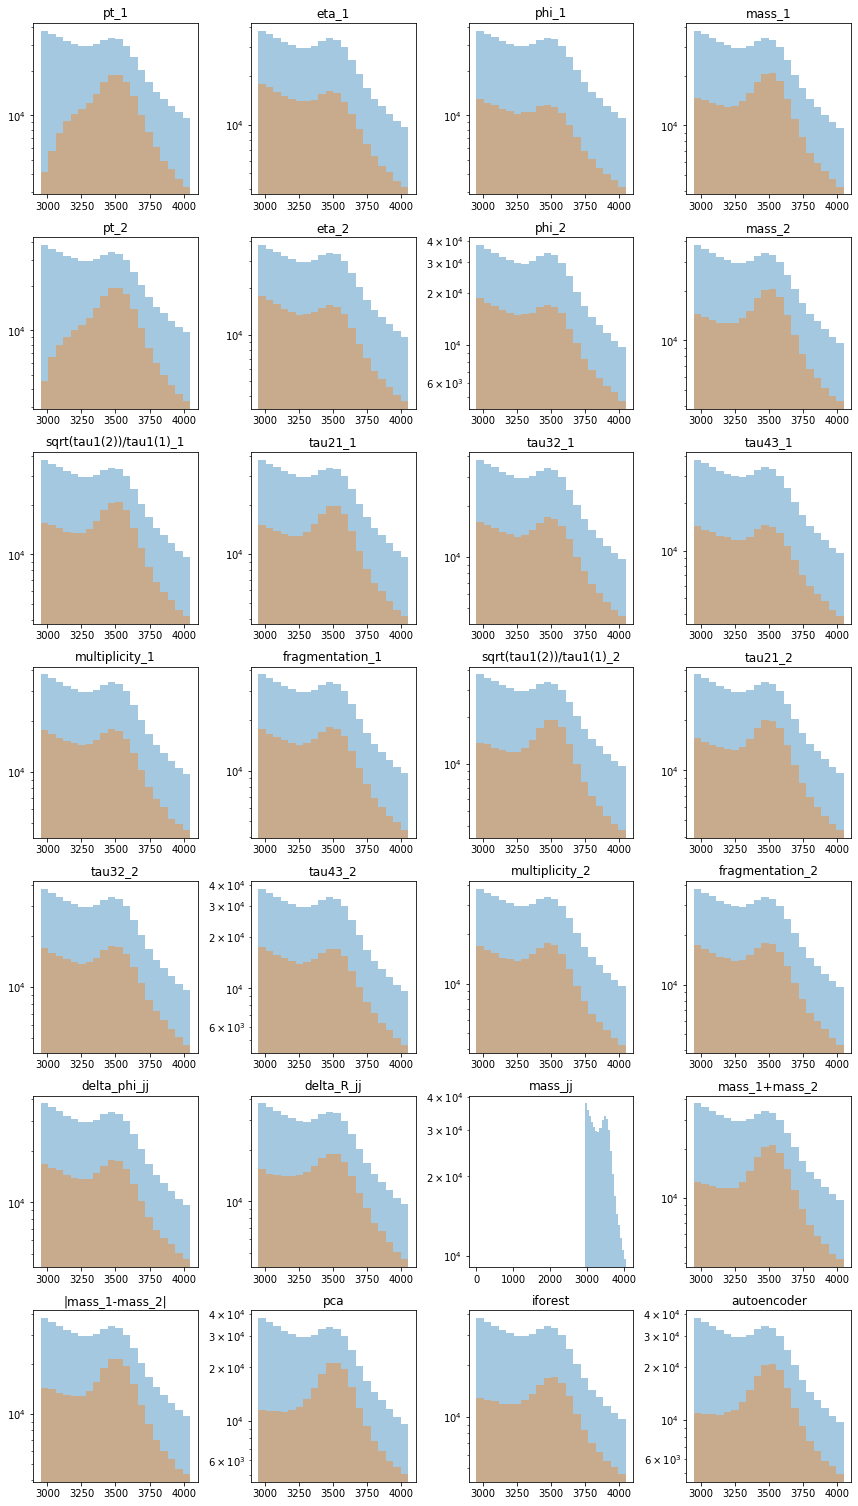

In [21]:
plt.figure(1, figsize=(12, 21))

for i, feature in enumerate(X3.columns):
    plt.subplot(7, 4, i+1)
    plt.title(feature)
    plt.yscale('log')
    
    quant3 = QuantileTransformer()
    X_feat = quant3.fit_transform(X3[feature].values.reshape(-1, 1))
    xgbc = XGBClassifier(tree_method='hist', n_estimators=10, max_depth=3)
    xgbc.fit(X_feat, y1)
    probas = xgbc.predict_proba(X_feat).T[1]
    
    plt.hist(df2['mass_jj'], bins=20, alpha=0.4)
    plt.hist(df2[probas > np.quantile(probas, 0.5)]['mass_jj'], bins=20, alpha=0.4)
    
plt.tight_layout(True)
plt.savefig(os.path.join(image_dir, 'xgboost_features_vs_mjj.png'))
plt.show()

## Feature Selection using Correlations

Look at correlation between feature and signal region/sideband region target. In particular, look at the difference in the correlation between true signal and true background events

In [75]:
df_sb_corr = pd.merge(
    df2[df2['is_signal'] == 1].corr()['signal_region'],
    df2[df2['is_signal'] == 0].corr()['signal_region'],
    how='inner',
    left_index=True,
    right_index=True,
    suffixes=('_signal', '_background')
)

In [76]:
df_sb_corr[
    (np.abs(df_sb_corr['signal_region_signal']) > 0.01) & 
    (np.abs(df_sb_corr['signal_region_background']) < 0.04)
]

,signal_region_signal,signal_region_background
mass_2,-0.025757,0.022506
sqrt(tau1(2))/tau1(1)_1,-0.040284,0.001722
tau21_1,-0.044415,-0.007142
tau32_1,0.024404,-0.005386
tau43_1,0.015655,-0.004970
multiplicity_1,-0.012363,0.007554
sqrt(tau1(2))/tau1(1)_2,-0.096126,0.005074
tau21_2,-0.082249,-0.006089
tau32_2,0.031886,-0.007799
tau43_2,0.011706,-0.005691


In [84]:
df_sb_corr.iloc[-3:]

,signal_region_signal,signal_region_background
pca,0.091680,0.060173
iforest,-0.045935,0.040584
autoencoder,0.063437,0.063057
